<a href="https://colab.research.google.com/github/lumizel/AI_26/blob/main/05_01_%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MBC 마켓에서 신상품으로 캔 와인을 판매하려고 한다.
# 주류는 온라인 판매가 안되서 온라인 예약 후에
# 오프라인매장에서 구매를 유도하려고 함

# 입고된 와인을 보니 레드와인인지 화이트와인인지 구분표시가 안되었음
# 캔에 인쇄된 알콜도수, 당도, pH 값으로 와인 종류를 구별해보자.

# 품질확인용으로 뜯은 캔이 테스트용으로 있고 이것을 데이터로 활용
# 로지스틱 회귀 모델로 적용을 해서 알아보자.

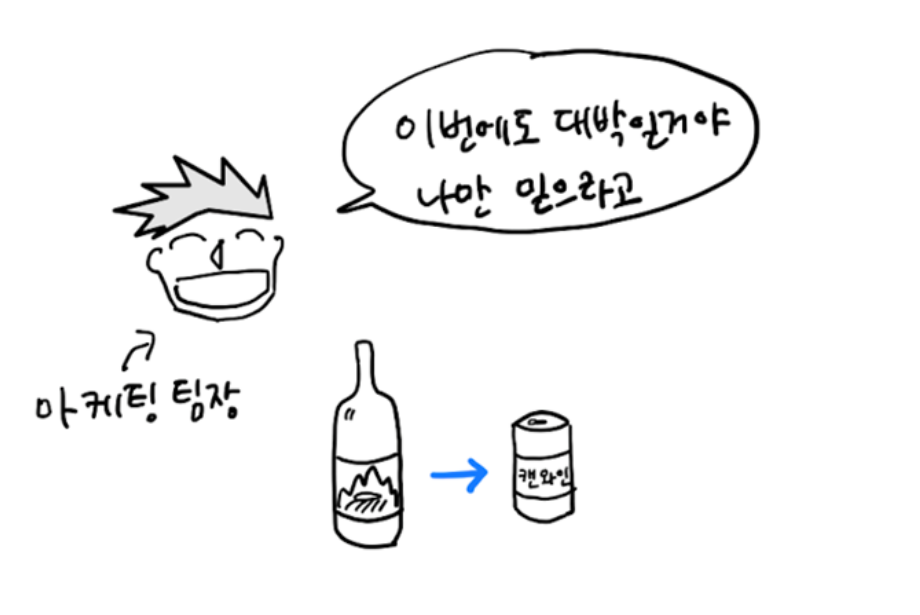

In [ ]:
# 와인의 특성화된 데이터를 넣자.
import pandas as pd
import requests
import io
import urllib3

# 1. "보안 검증 안 해도 되니까 경고 띄우지 마!" 설정
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# 2. requests로 데이터를 강제로 가져오기 (verify=False가 핵심)
url = 'https://bit.ly/wine_csv_data'
response = requests.get(url, verify=False)

# 3. 판다스에게 주소 대신 '이미 가져온 데이터'를 읽으라고 시키기
# pd.read_csv('https://...') 대신 아래 방식을 써야 에러가 안 납니다!
wine = pd.read_csv(io.StringIO(response.text))

wine.head()
# 알콜, 당도, 산도, 클래스(타킷 =0(레드와인), 1(화이트와인))
# 데이터에서 화이트와인이 양성클래스로 화이트와인을 표시하는 문제

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [ ]:
wine.info()
# 결과 6497개의 샘플 4개의 열(실수형)
# Non-Null 누락된 값이 없음

<class 'pandas.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [ ]:
wine.describe()
# mean=평균, std=표준편차, min=최소,
# 25%=1사분위수, 50%=중간값(2 사분위), 75%=3사분위, max=(100%, 4사분위)
# 사분위수 : 데이터를 순서대로 4등분한 값

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [ ]:
# StandardScaler 클래스로 특성을 표준화 해야함
data = wine[['alcohol', 'sugar', 'pH']].to_numpy() # 넘파이 배열로 변환
# 와인 데이터 프레임에서 처음3개의 열을 넘파이 배열로 바꿔서 data 배열에 저장

target = wine['class'].to_numpy()
# class 열을 넘파이 배열로 바꿔서 target(정답) 배열에 저장

print(data) # 훈련입력값

[[ 9.4   1.9   3.51]
 [ 9.8   2.6   3.2 ]
 [ 9.8   2.3   3.26]
 ...
 [ 9.4   1.2   2.99]
 [12.8   1.1   3.34]
 [11.8   0.8   3.26]]


In [ ]:
print(target)

[0. 0. 0. ... 1. 1. 1.]


In [ ]:
# 훈련세트와 테스트 세트로 나눔
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)
# train_test_split()함수는 설정값을 지정하지 않으면 25%를 테스트 세트로 지정
# test_size=0.2를 이용해서 20% 정도만 테스트 세트로 지정
print(train_input.shape, test_input.shape) # 6496 * 0.8 = 5196.8

(5197, 3) (1300, 3)


In [ ]:
from sklearn.preprocessing import StandardScaler
# 훈련세트 전처리 - 표준점수 단위 맞춰줌

ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)
print(train_scaled)
print('-----------------------------------')
print(test_scaled)

[[ 0.01376574  0.4646116  -0.16888369]
 [ 1.60871671 -0.70299854  0.26967864]
 [ 1.10504798 -0.70299854  1.20945505]
 ...
 [-0.82568214  0.0267578   0.14437512]
 [-0.82568214  0.52716215 -0.23153545]
 [-0.82568214 -0.57789745  1.83597265]]
-----------------------------------
[[ 1.44082714  1.52797084  0.26967864]
 [-0.48990299 -0.68214836  0.3323304 ]
 [ 1.27293756  0.40206106 -0.23153545]
 ...
 [ 1.60871671 -0.76554908 -0.16888369]
 [-0.90962693  0.88161523  0.52028568]
 [-1.49724045  2.09092573 -1.98578474]]


In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression

lr = LogisticRegression() # 로지스틱 회귀 모델 훈련
lr.fit(train_scaled, train_target) # 훈련 시작

print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))
# 결론 80점 이하로 점수가 낮게 나옴(과소 적합)

0.7808350971714451
0.7776923076923077


In [ ]:
# 제출용 보고서를 만들어 보자.
print(lr.coef_, lr.intercept_) # 로지스틱 회귀(계수=가중치, 절편=더해지는값)

[[ 0.51268071  1.67335441 -0.68775646]] [1.81773456]


In [ ]:
# 알콜 도수값이 0.51268071를 곱하고,
# 당도에 1.67335441를 곱하고,
# pH값에 -0.68775646을 곱한 다음 모두 더함
# 위에 나온 값에 절편 1.81773456을 더함
# 이값이 0보다 크면 화이트 와인, 작으면 레드와인
# 현재 77% 정도 정확히 화이트 와인으로 분류 완료!!!!

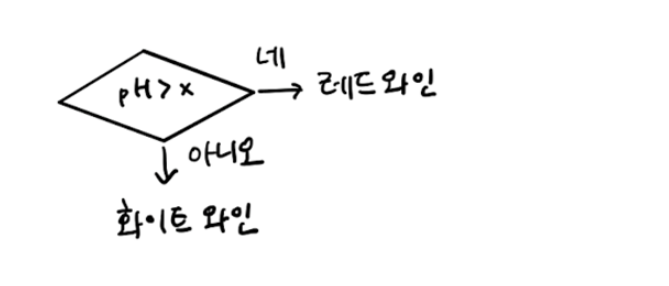

In [ ]:
# 결정 트리 - 이유를 설명하기 쉽다
# if문을 사용하는 것과 유사
from sklearn.tree import DecisionTreeClassifier # 디시전 - 결정

# DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))
# 과대 적합됨 (훈련점수 99.69% , 테스트 점수 85.92%)

0.996921300750433
0.8592307692307692


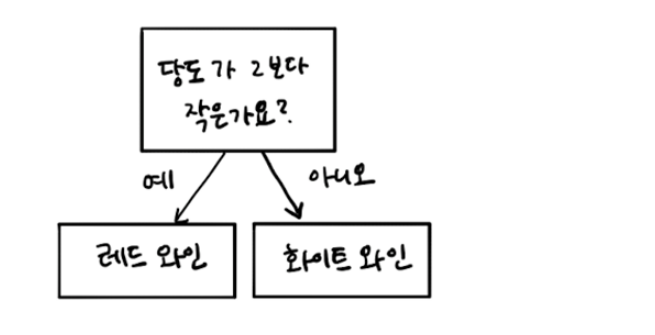

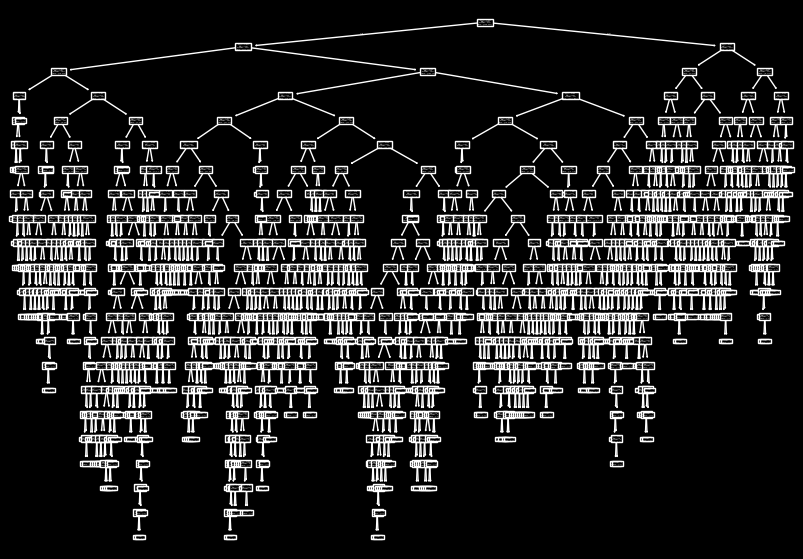

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 7)) # figure(형태,도형)
# figsize=(20,15) 그래프의 사이즈(가로인치, 세로인치)
plot_tree(dt)
plt.show()
# 맨위 노드(루트노드),맨아래노드(리프노드)

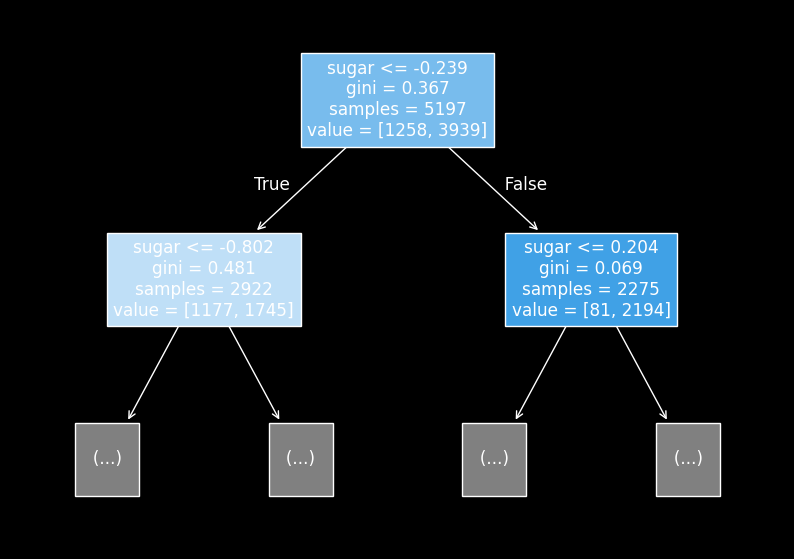

In [ ]:
plt.figure(figsize=(10, 7))
plot_tree(dt, max_depth=1,filled=True,feature_names=['alcohol','sugar','pH'])
# max_depth=1 루트노드를 제외
# filled=True 클래스에 맞게 색칠
# feature_names=['alcohol', 'sugar', 'pH']
plt.show()
# sugar가 -0.239보다 이상이면 false
# sugar가 -0.239보다 같거나 작으면 true (왼쪽 가지로)
# 총샘플 수는 5,197개, 음성클래스(레드와인) 1,258개, 양성클래스(화이트와인) 3,939개
    # 아래쪽 노드에 왼쪽 노드를 살펴보자
    # 이 노드는 당도가 더 낮은지를 물어보는 노드 (-0.802)
    # 당도가 -0.802와 같거나 낮다면 다시 왼쪽으로
    # 그렇지 않으면 오른쪽으로 이동, 음성클래스 1,177개, 양성클래스 1,745개

    # 오른쪽 노드를 보면 음성클래스가 81개, 양성클래스 2,194개로
    # 대부분이 화이트 와인 샘플이 이 노드로 이동됨

# gini = 0.367 (불순도)
# sample = 5197 (총샘플수)
# value = 값 (1258(1), 3939(0))

In [ ]:
# 노드의 바탕색을 유심히 보면 루트노드보다 더 진하고, 왼쪽 노드는 연해짐
# filled=True로 지정하면 클래스 마다 색깔을 지정함, 비율이 높아지면 점점 진하게 표시함

# 결정트리에서 예측하는 방법은 간단한데, 리프노드에서 가장 많은 클래스가 예측 클래스가 됨
# 만약 이결정 트리로 성장을 멈춘다면 왼쪽 노드에 도달한 샘플과 오른쪽 노드에 도달한
# 샘플은 모두 양성 클래스로 예측된다. (양성 클래스가 많아서)

# gini 불순도로 노드에서 데이터를 분할할 기준을 정하는 값

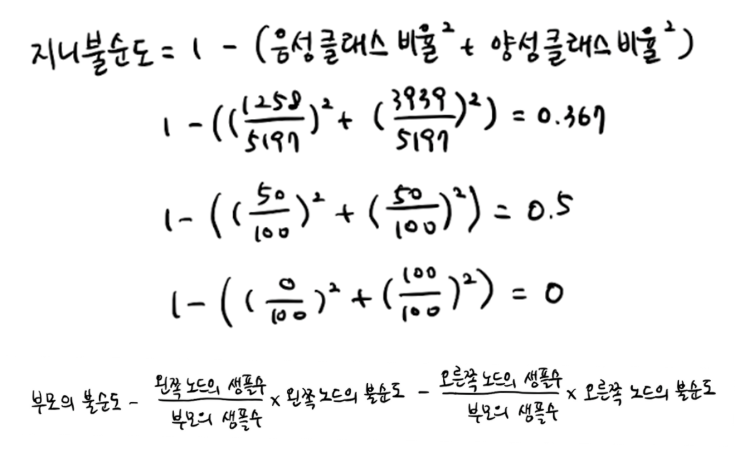

In [ ]:
# 가지치기 : 열매를 잘 맺기 위해서 가지치기를 하듯이 결정트리에서도 사용한다
# 가지치기를 하지 않으면 무작정 끝까지 자라나는 트리를 만듦
# 트리의 깊이를 지정하면 된다 - depth

# 새로운 객체를 깊이 3으로 만든다
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


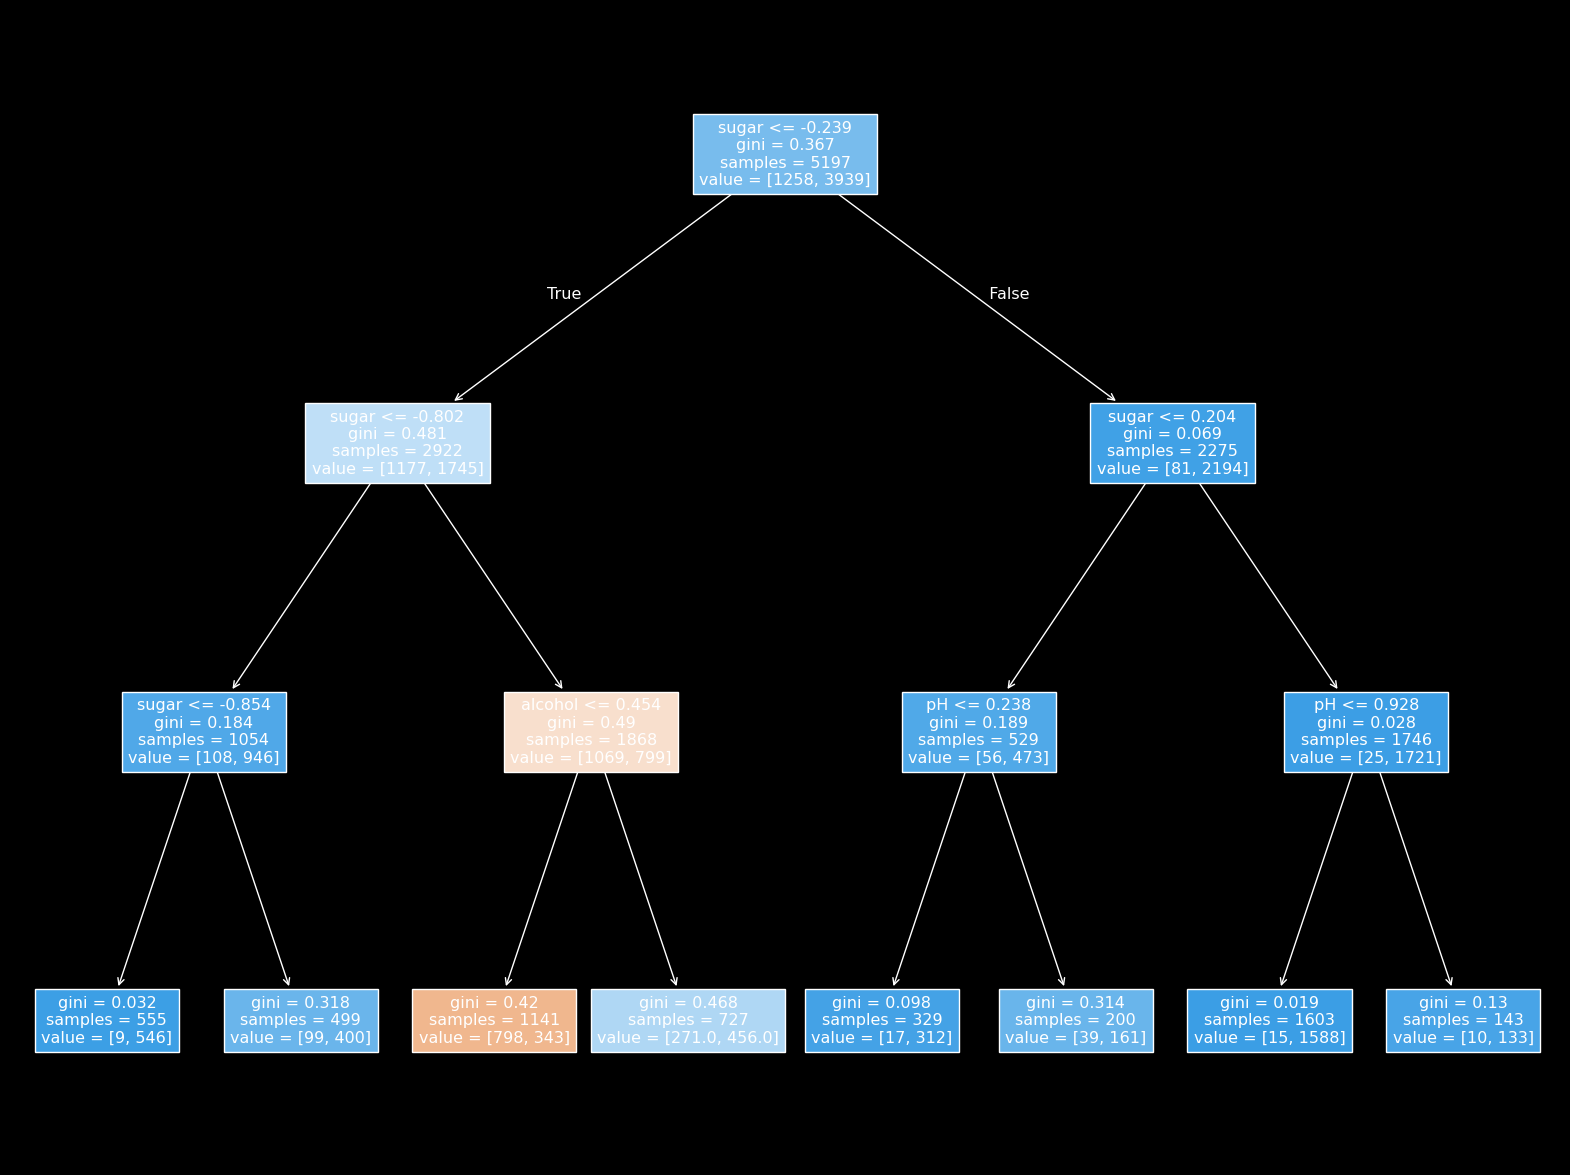

In [ ]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True,feature_names=['alcohol','sugar','pH'])
plt.show()

In [ ]:
# 그래프 분석
# 루트노드(depth=0) 다음 깊에 있는 depth=1 노드는 모두 당도를 기준으로 훈련세트를 나눔
# 하지만 depth=2에서는 맨 왼쪽 노드만 당도를 기준으로 나누고 외쪽에서 두번째 노드는 알콜
# 도수를 기준으로 나눔 오른쪽 두 노드는 pH를 사용합니다.

# 깊이 3에 있는 노드가 최종 노드인 리프 노드이다.
# 왼쪽에서 세번째에 있는 노드만 음성 클래스가 더 많다.
# 이 노드에 도착해야만 레드와인으로 예측함
# 결론 : 당도는 -0.239보다 작고 -0.802보다 커야 함
#        알콜 도수는 0.454보다 작으면 레드 와인이다.

# -0.802라는 음수로된 당도를 상사에게 보고 할수 있나??
# 표준화(표준점수) 전처리를 하지 않고 결정 트리를 사용해보자.(특성값에 스케일은 효과가 없다.)
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))  # 84.52%
print(dt.score(test_input, test_target))    # 84.15% -> 표준화 점수 사용 안함

0.8454877814123533
0.8415384615384616


In [ ]:
import numpy as np

sample = np.array([9.5,1.6,3.17])
sample = sample.reshape(1, -1)
dt.predict(sample)
# 타킷 =0(레드와인), 1(화이트와인)

array([1.])

In [ ]:
pred = dt.predict([[9.5,1.6,3.17]])

if pred[0] == 0:
    print("Red Wine")
else:
    print("White Wine")

White Wine


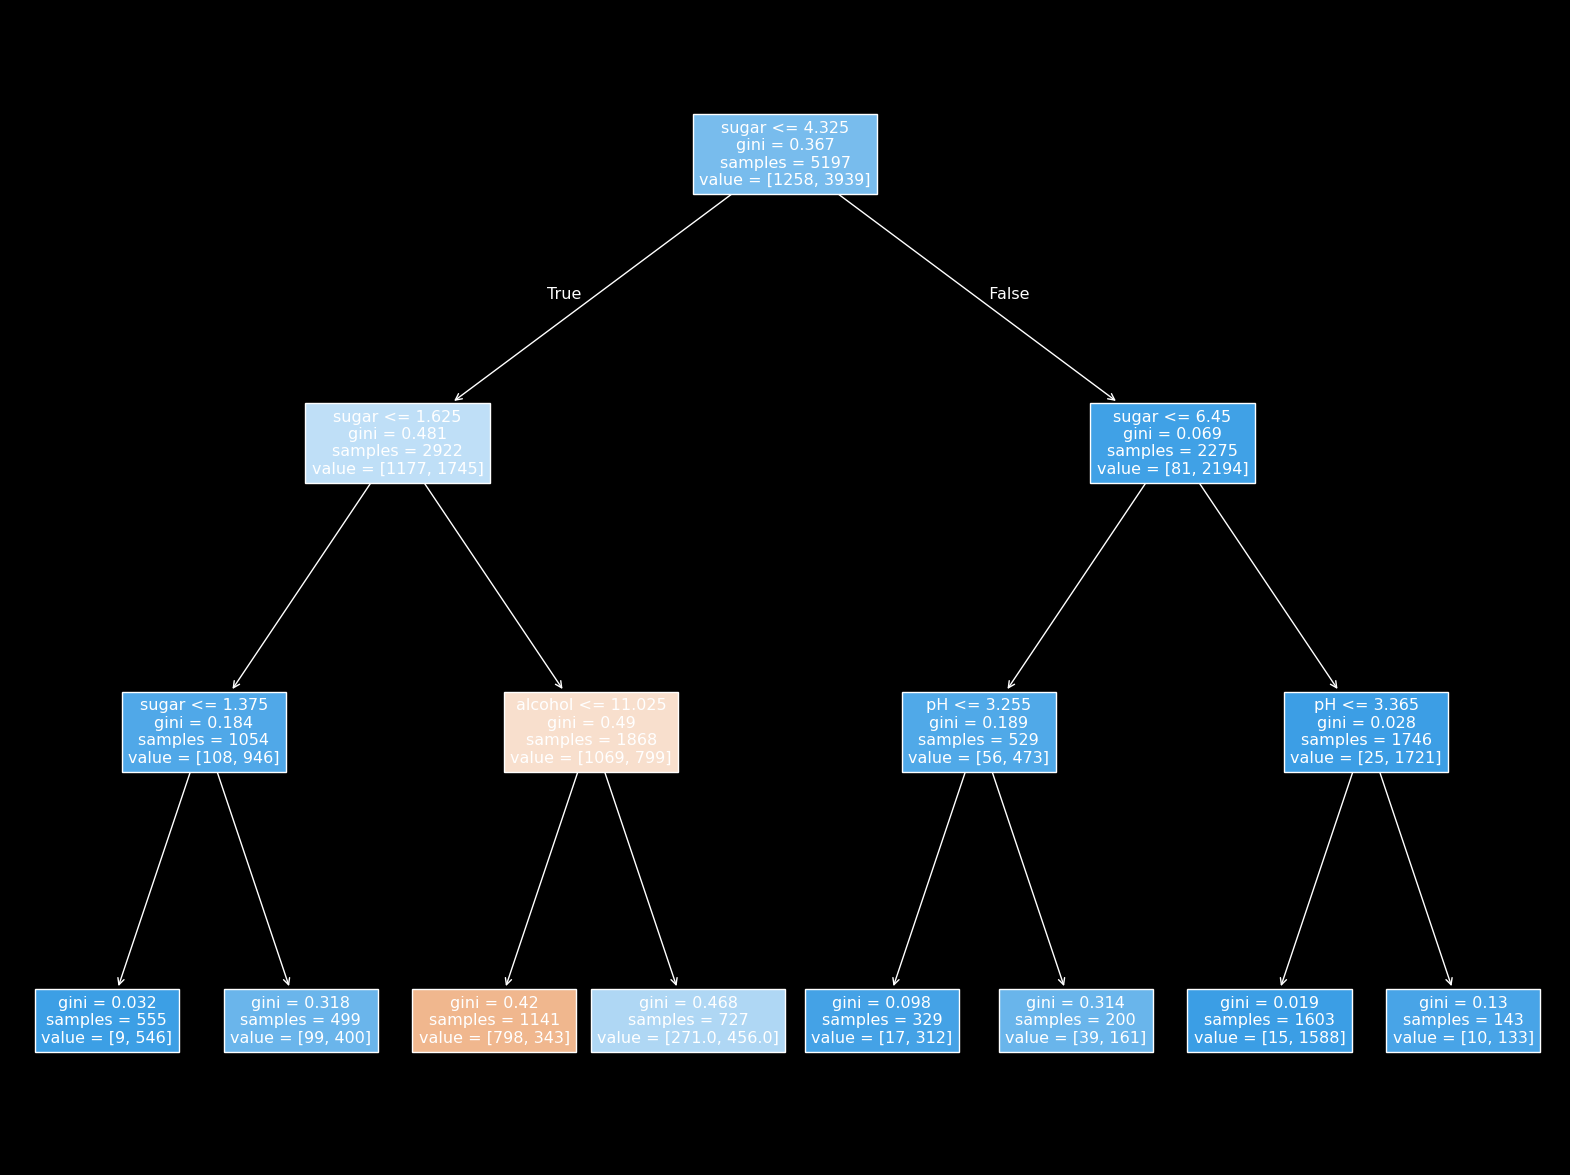

In [ ]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True,feature_names=['alcohol','sugar','pH'])
plt.show()

In [ ]:
# 결과 보고서에 넣을 내용
# 당도가 1.625보다 크고 4.325보다 작은 와인 중에
# 알콜 도수가 11.025와 같거나 작은것이 레드와인 으로 판단됨.
# 위 트리에서 주황색 부분이 레드와인으로 판단되고 나머지는 화이트와인이다.!!!

In [ ]:
# 결정트리는 어떤 특성이 가장 유용했는지 나타내는 특성 중요도를 계산
print(dt.feature_importances_)
# [0.12345626 0.86862934 0.0079144 ] = 다 더하면 1이 나와야 함
#   알콜 도수    당도         ph     -> 순서는 입력값

[0.12345626 0.86862934 0.0079144 ]


In [ ]:
# 좌우가 균일하지 않은 트리
dt = DecisionTreeClassifier(min_impurity_decrease=0.0005,random_state=42)
# min_impurity_decrease : 최소 불순도
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8874350586877044
0.8615384615384616


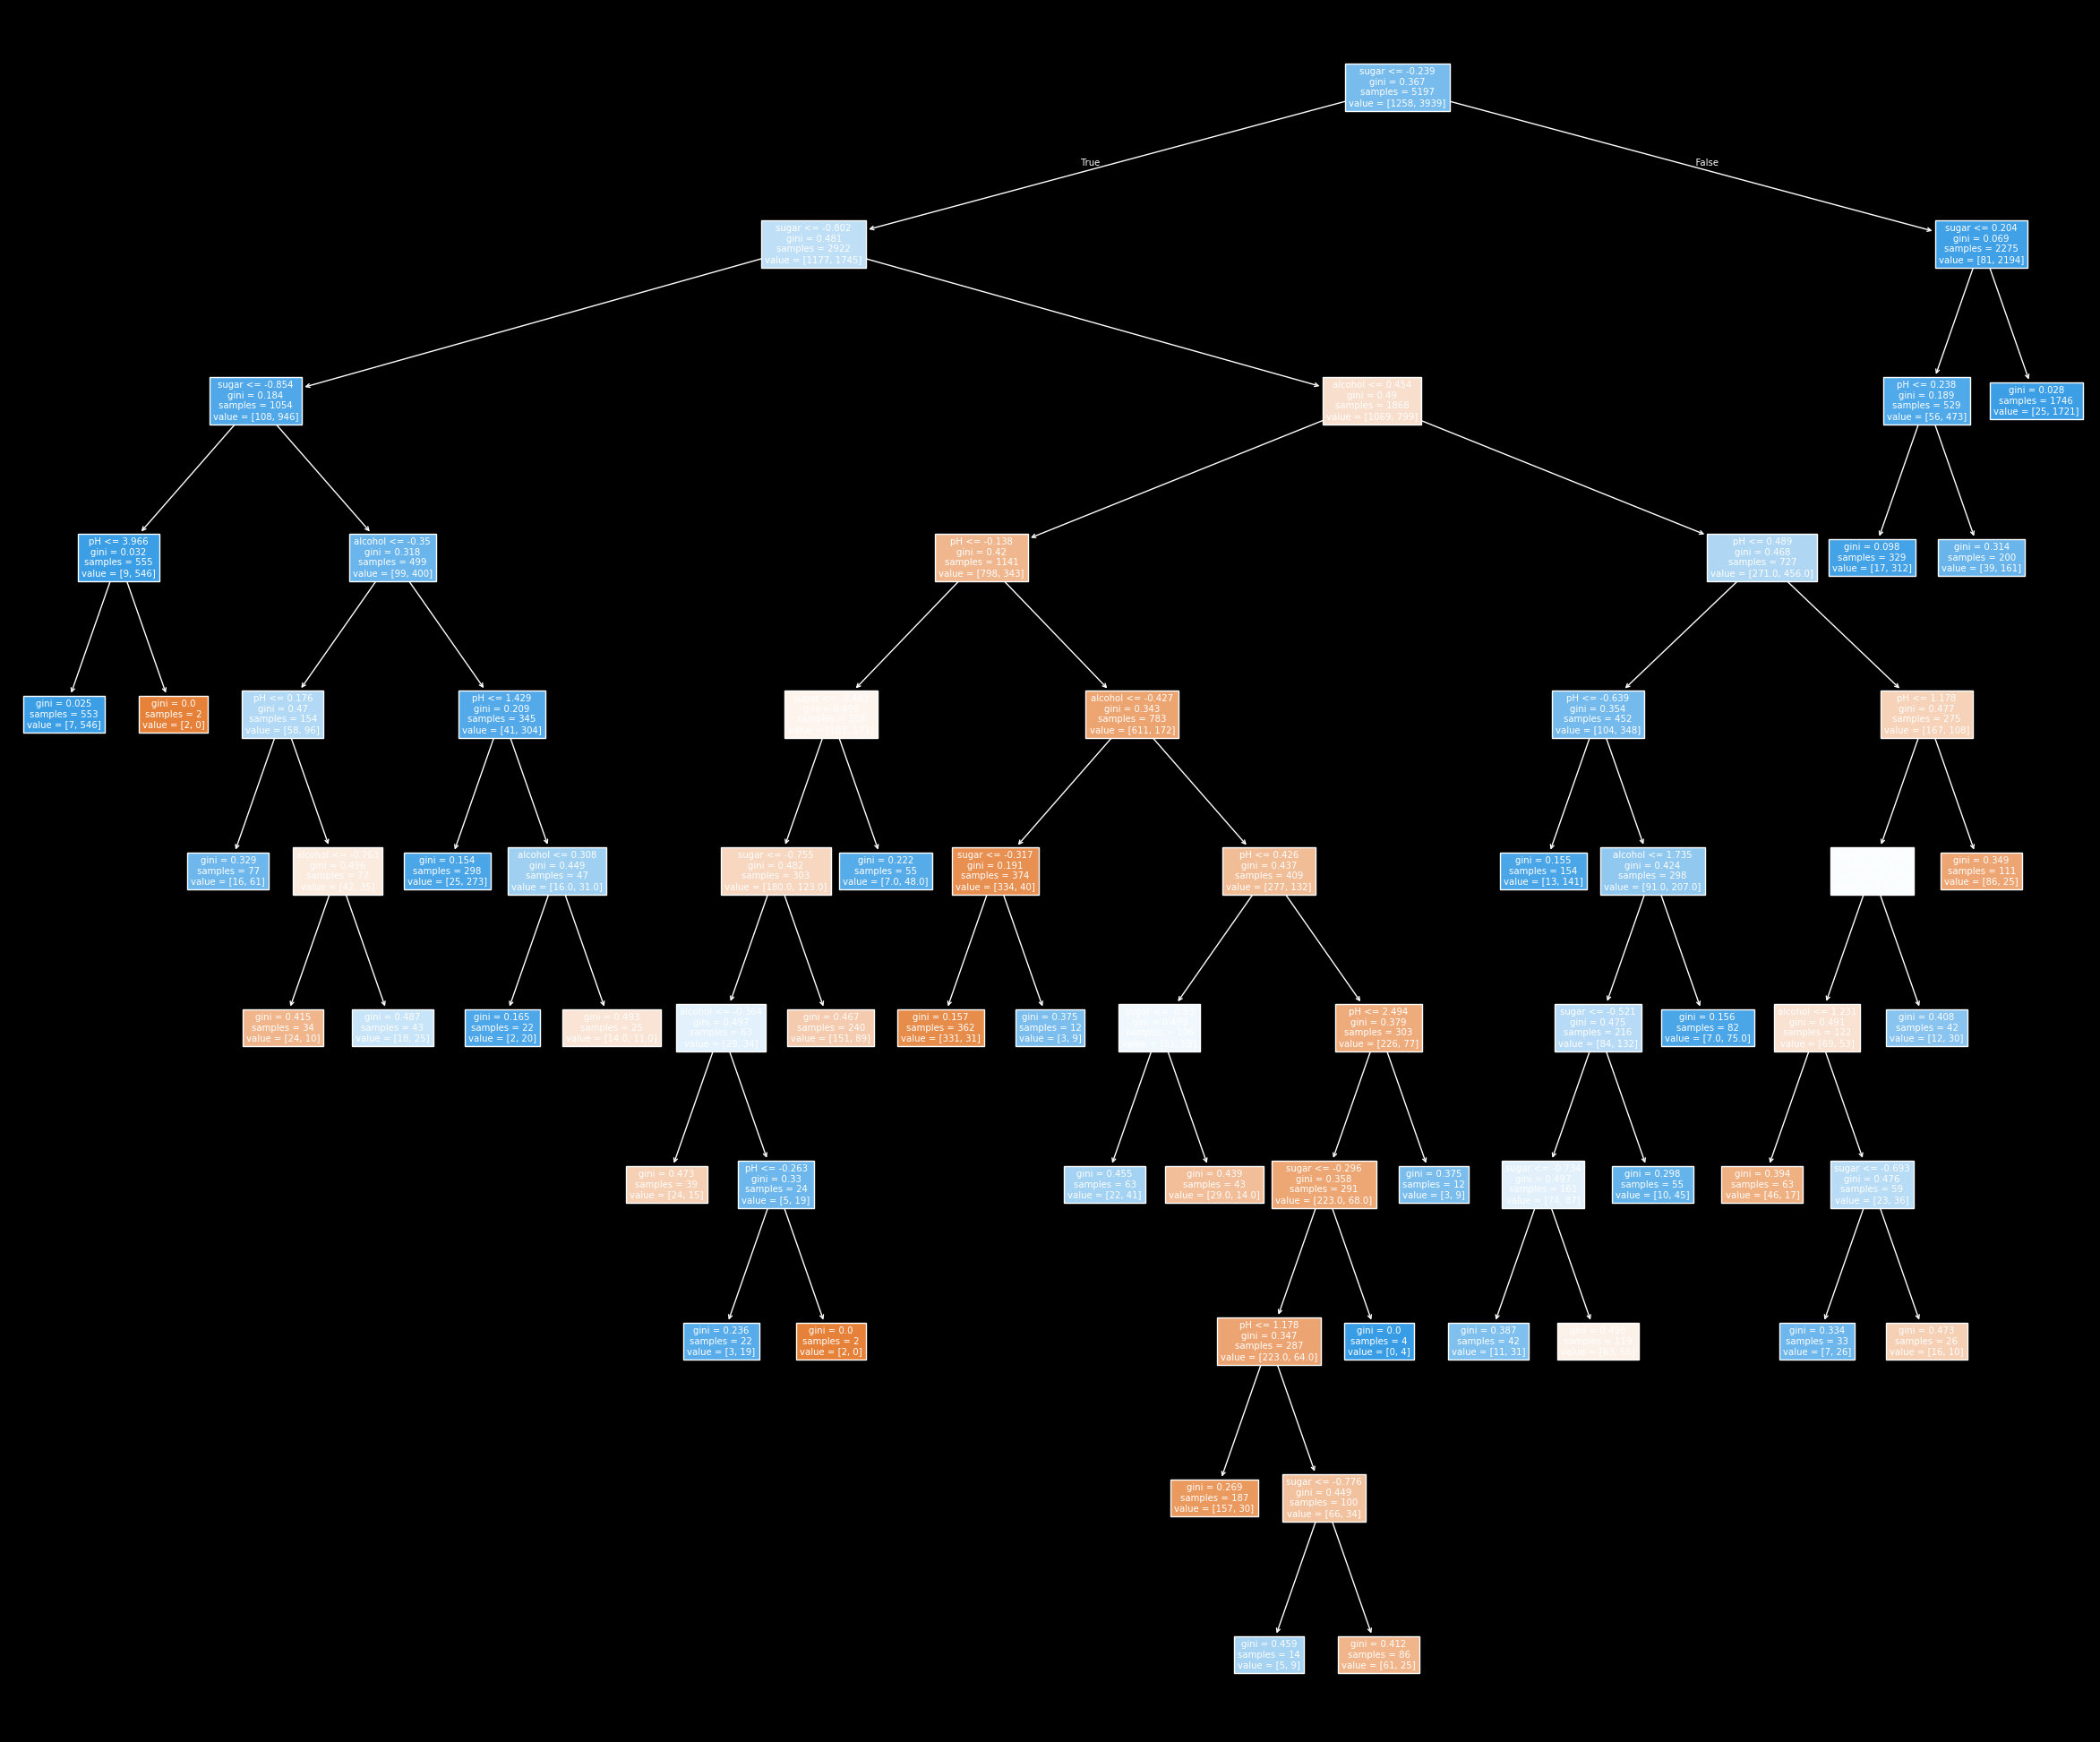

In [ ]:
ssplt.figure(figsize=(30,25))
plot_tree(dt, filled=True,feature_names=['alcohol','sugar','pH'])
plt.show()